In [1]:

from pathlib import Path
import numpy as np
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import sys, pathlib

root = pathlib.Path.cwd().parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

from Motivation import (
    DZ_DEFAULT, Z_MAX_DEFAULT, Z_TW_MIN_DEFAULT, Z_TW_MAX_DEFAULT,
    read_head_fits, read_fitres_any, standardize_fitres, read_phot_fits,
    ross_qc_with_report, densest_year_window,
    nz_hist, write_binned_catalogs, load_binned_catalogs,
    run_binned_forecast,summarize_y1_counts_in_range,
    show_fig_y1_nz, plot_lcdm_1d, plot_corner, plot_lcdm_1d_comparison, plot_corner_comparison,
)

# --- Paths (keep existing defaults; make overridable) ---
BASE = Path("/Users/tz/Documents/GitHub/Lsst-Twilight-SNe/Motivation/data_snana_EP_LSST")
HEAD_HIGHZ = BASE / "1_SIM/PIP_EP-LSST_LSST_P21_HIGHZ/PIP_EP-LSST_LSST_P21_HIGHZ_SNIaMODEL00-0001_HEAD.FITS.gz"
HEAD_LOWZ  = BASE / "1_SIM/PIP_EP-LSST_LSST_P21_LOWZ/PIP_EP-LSST_LSST_P21_LOWZ_SNIaMODEL00-0001_HEAD.FITS.gz"
PHOT_HIGHZ = BASE / "1_SIM/PIP_EP-LSST_LSST_P21_HIGHZ/PIP_EP-LSST_LSST_P21_HIGHZ_SNIaMODEL00-0001_PHOT.FITS.gz"
PHOT_LOWZ  = BASE / "1_SIM/PIP_EP-LSST_LSST_P21_LOWZ/PIP_EP-LSST_LSST_P21_LOWZ_SNIaMODEL00-0001_PHOT.FITS.gz"
FITRES_HIGHZ_ASCII = BASE / "2_LCFIT/PIP_EP-LSST_LSST_P21_HIGHZ/FITOPT000.FITRES.gz"
FITRES_LOWZ_ASCII  = BASE / "2_LCFIT/PIP_EP-LSST_LSST_P21_LOWZ/FITOPT000.FITRES.gz"
FITRES_LOWZ_ROOT   = BASE / "2_LCFIT/PIP_EP-LSST_LSST_P21_LOWZ/FITOPT000.ROOT.gz"

DERIVED = Path("/Users/tz/Documents/GitHub/Lsst-Twilight-SNe/Motivation/derived")
DERIVED.mkdir(parents=True, exist_ok=True)

DZ = DZ_DEFAULT
Z_MAX = Z_MAX_DEFAULT
Z_TW_MIN, Z_TW_MAX = Z_TW_MIN_DEFAULT, Z_TW_MAX_DEFAULT


In [2]:

head_hi = read_head_fits(HEAD_HIGHZ)
head_lo = read_head_fits(HEAD_LOWZ)
head_all = pd.concat([head_lo, head_hi], ignore_index=True)

fit_hi = standardize_fitres(read_fitres_any(FITRES_HIGHZ_ASCII))
fit_lo = standardize_fitres(read_fitres_any(FITRES_LOWZ_ASCII if FITRES_LOWZ_ASCII.exists() else FITRES_LOWZ_ROOT))
fit_all = pd.concat([fit_lo, fit_hi], ignore_index=True)

# Type Ia & z-range (preserve original behavior)
if "SNTYPE" in head_all.columns:
    head_all = head_all.loc[head_all["SNTYPE"] == 1].copy()
head_all["z"] = pd.to_numeric(head_all.get("z", np.nan), errors="coerce")
head_all = head_all.loc[(head_all["z"] > 0) & (head_all["z"] <= Z_MAX)].copy()

fit_all["z"] = pd.to_numeric(fit_all.get("z", np.nan), errors="coerce")
fit_all = fit_all.loc[(fit_all["z"] > 0) & (fit_all["z"] <= Z_MAX)].copy()

phot_hi = read_phot_fits(PHOT_HIGHZ)
phot_lo = read_phot_fits(PHOT_LOWZ)

t0, t1 = densest_year_window(fit_all)
head_y1 = head_all.loc[(head_all["PKMJD"] >= t0) & (head_all["PKMJD"] < t1)].copy()

fit_qc = ross_qc_with_report(fit_all, head_hi=head_hi, phot_hi=phot_hi, head_lo=head_lo, phot_lo=phot_lo, phot_hi_path=PHOT_HIGHZ, phot_lo_path=PHOT_LOWZ, verbose=True)
fit_qc_y1 = fit_qc.loc[(fit_qc["PKMJD"] >= t0) & (fit_qc["PKMJD"] < t1)].copy()


[ROSS QC] FITPROB cut        keep=188012/191028 (98.4%)
[ROSS QC] x1 range           keep=186900/191028 (97.8%)
[ROSS QC] c range            keep=184970/191028 (96.8%)
[ROSS QC] PKMJDERR<=1d       keep=136457/191028 (71.4%)
[ROSS QC] x1ERR<=1           keep=145407/191028 (76.1%)
[ROSS QC] cERR<=0.05         keep= 72781/191028 (38.1%)
[ROSS QC] >=3 obs ±10d       keep=184157/191028 (96.4%)
[ROSS QC] no saturation      keep=191024/191028 (100.0%)
[ROSS QC] TOTAL          keep= 63365/191028 (33.2%)


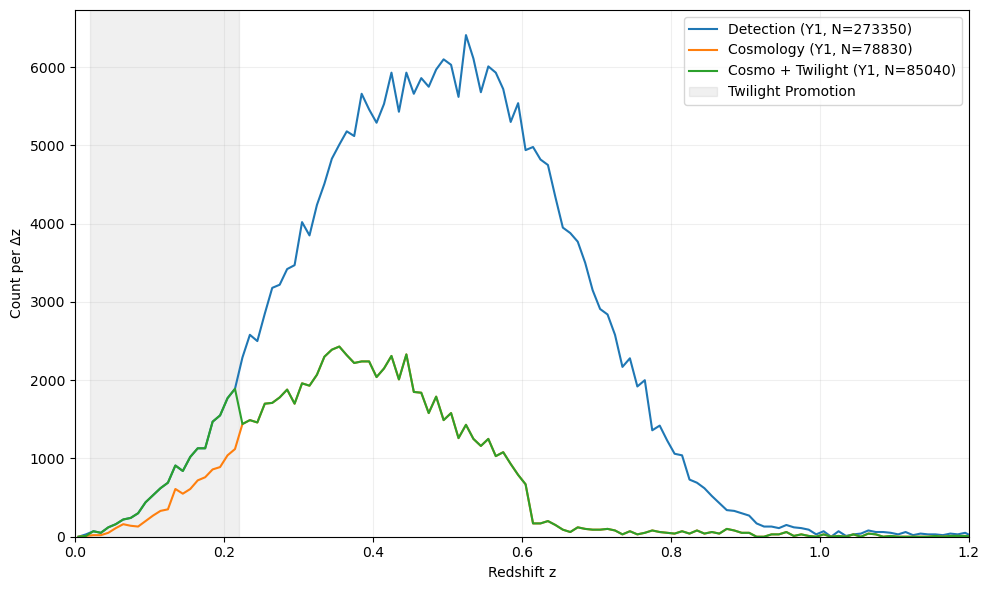

In [3]:

z_edges = np.arange(0.0, Z_MAX + DZ + 1e-12, DZ)
z_mid   = 0.5*(z_edges[:-1] + z_edges[1:])
N_det = nz_hist(head_y1["z"].to_numpy(float), z_edges) * 10
N_cos = nz_hist(fit_qc_y1["z"].to_numpy(float), z_edges) * 10
band = (z_edges[:-1] >= Z_TW_MIN) & (z_edges[1:] <= Z_TW_MAX)
N_cos_tw = N_cos.copy()
N_cos_tw[band] = np.maximum(N_cos_tw[band], N_det[band])

show_fig_y1_nz(z_mid, N_det, N_cos, N_cos_tw=N_cos_tw, DZ=DZ, Z_TW_MIN=Z_TW_MIN, Z_TW_MAX=Z_TW_MAX, Z_MAX=Z_MAX)


In [4]:
print("for redshift range 0.02-0.06, we have:",summarize_y1_counts_in_range(z_mid, N_det, N_cos, N_cos_tw=N_cos_tw, z_min=0.02, z_max=0.06, dz=DZ))

print("for redshift range 0.02-0.10, we have:",summarize_y1_counts_in_range(z_mid, N_det, N_cos, N_cos_tw=N_cos_tw, z_min=0.02, z_max=0.10, dz=DZ))

print("for redshift range 0.02-0.14, we have:",summarize_y1_counts_in_range(z_mid, N_det, N_cos, N_cos_tw=N_cos_tw, z_min=0.02, z_max=0.14, dz=DZ))

print("for redshift range 0.06-0.10, we have:",summarize_y1_counts_in_range(z_mid, N_det, N_cos, N_cos_tw=N_cos_tw, z_min=0.06, z_max=0.10, dz=DZ))

print("for redshift range 0.10-0.14, we have:",summarize_y1_counts_in_range(z_mid, N_det, N_cos, N_cos_tw=N_cos_tw, z_min=0.10, z_max=0.14, dz=DZ))

for redshift range 0.02-0.06, we have: {'N_det': 400, 'N_cos': 200, 'N_cos_tw': 400}
for redshift range 0.02-0.10, we have: {'N_det': 1600, 'N_cos': 830, 'N_cos_tw': 1600}
for redshift range 0.02-0.14, we have: {'N_det': 4350, 'N_cos': 2390, 'N_cos_tw': 4350}
for redshift range 0.06-0.10, we have: {'N_det': 1200, 'N_cos': 630, 'N_cos_tw': 1200}
for redshift range 0.10-0.14, we have: {'N_det': 2750, 'N_cos': 1560, 'N_cos_tw': 2750}


In [5]:

base_csv, tw_csv = write_binned_catalogs(head_y1, fit_qc_y1, dz=DZ, z_max=Z_MAX, derived_dir=DERIVED, base_label="ep_lsst")
bins = load_binned_catalogs(DERIVED, z_max=Z_MAX)
df_wfd_bin     = bins["WFD"]
df_twfull_bin  = bins["WFD+Twilight"]
df_twguess_bin = bins.get("WFD+Twilight (Guess)")


AttributeError: 'float' object has no attribute 'fillna'

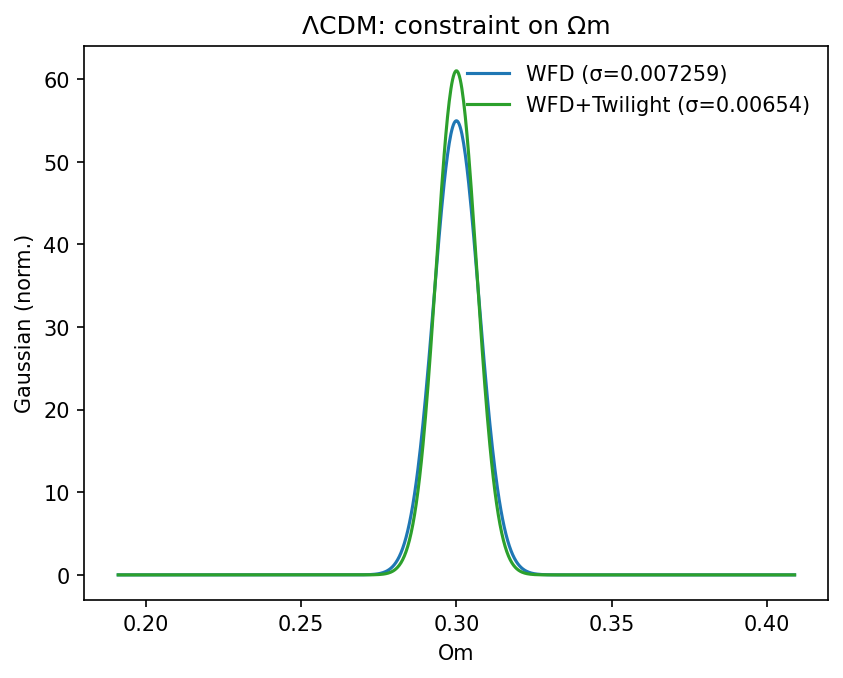

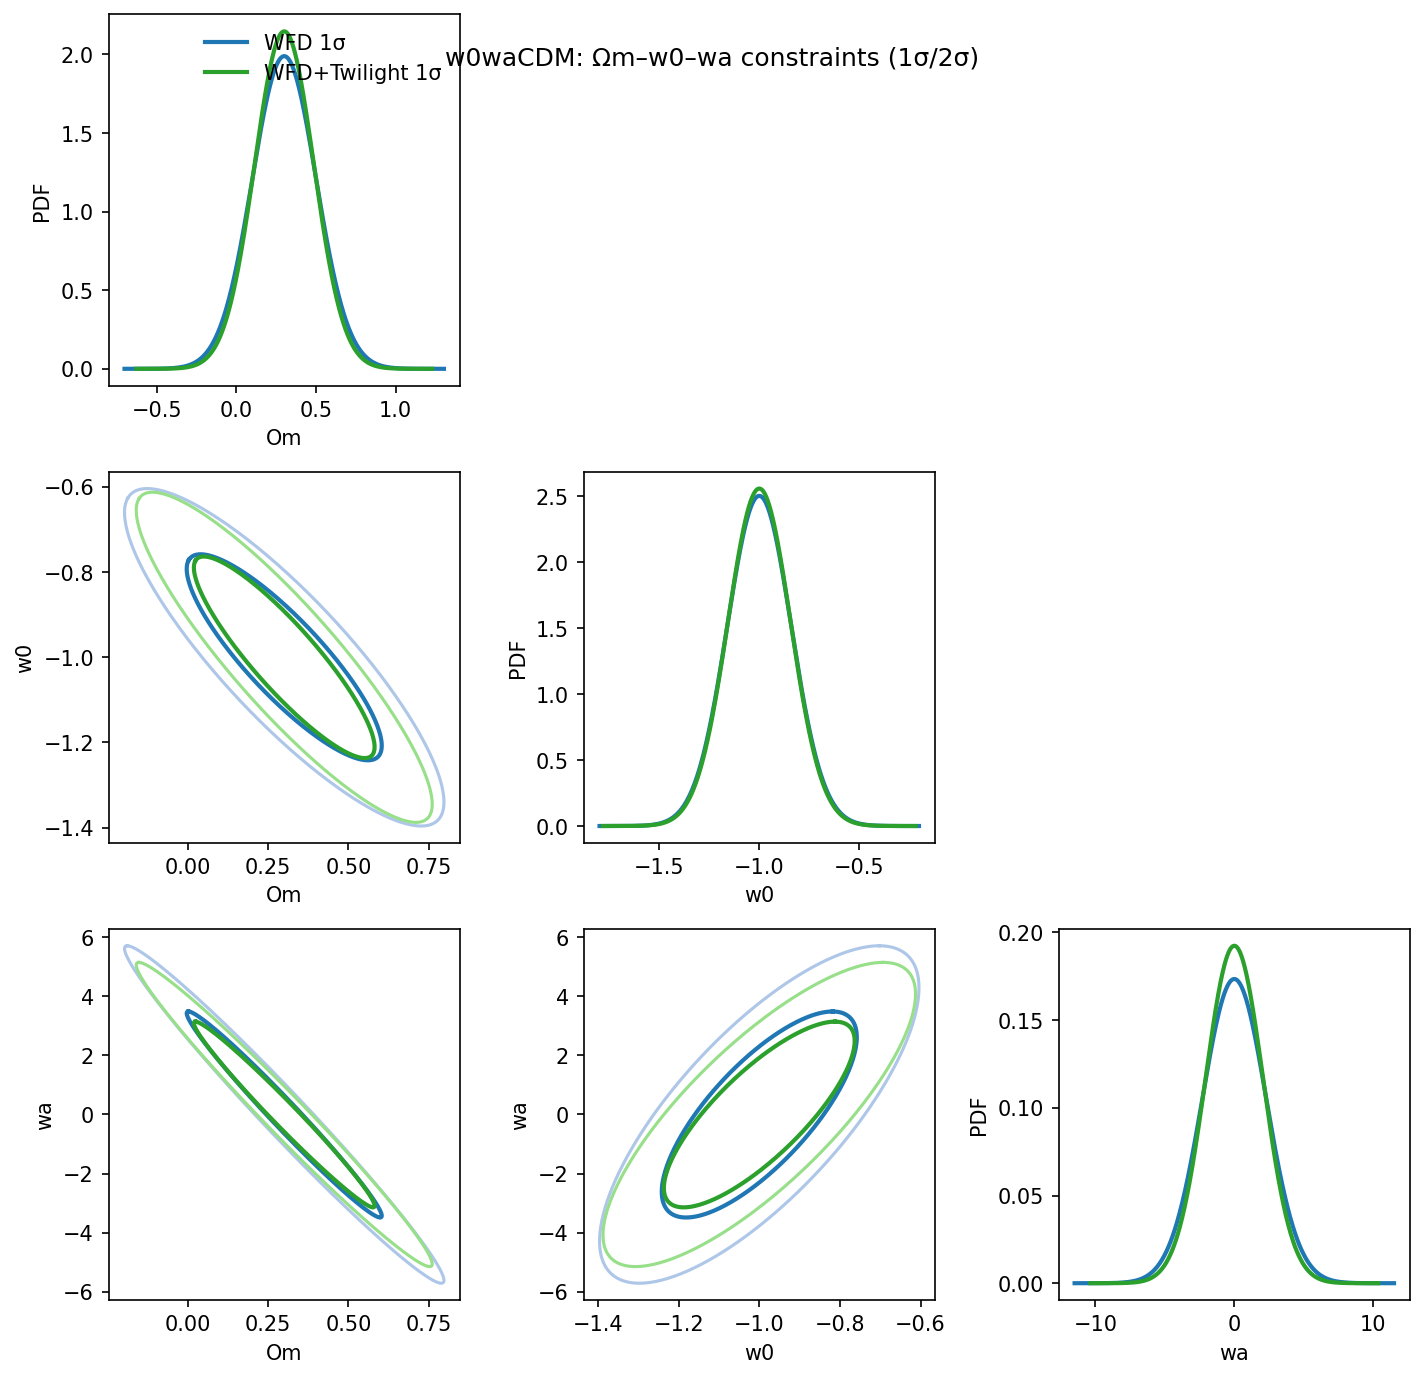

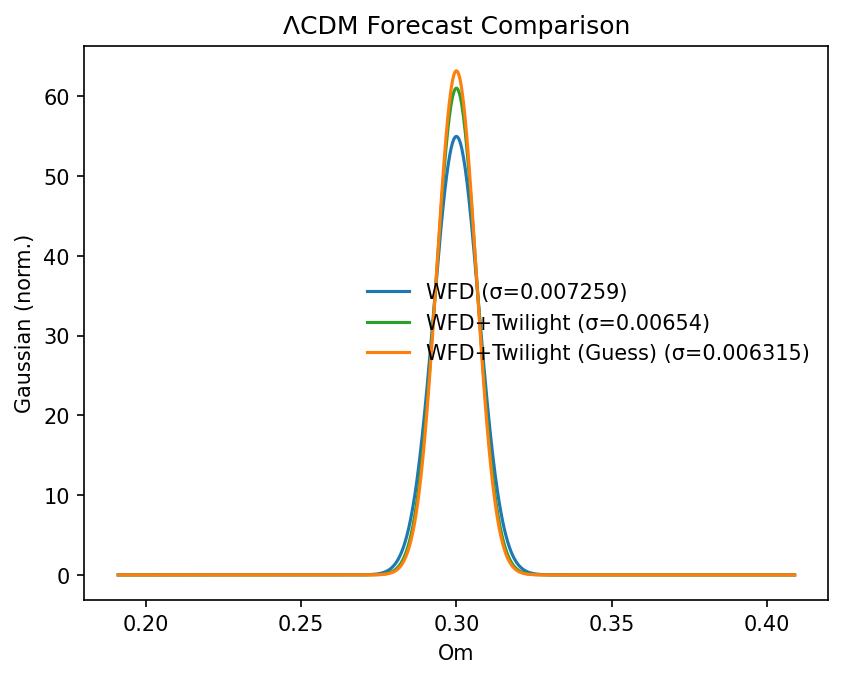

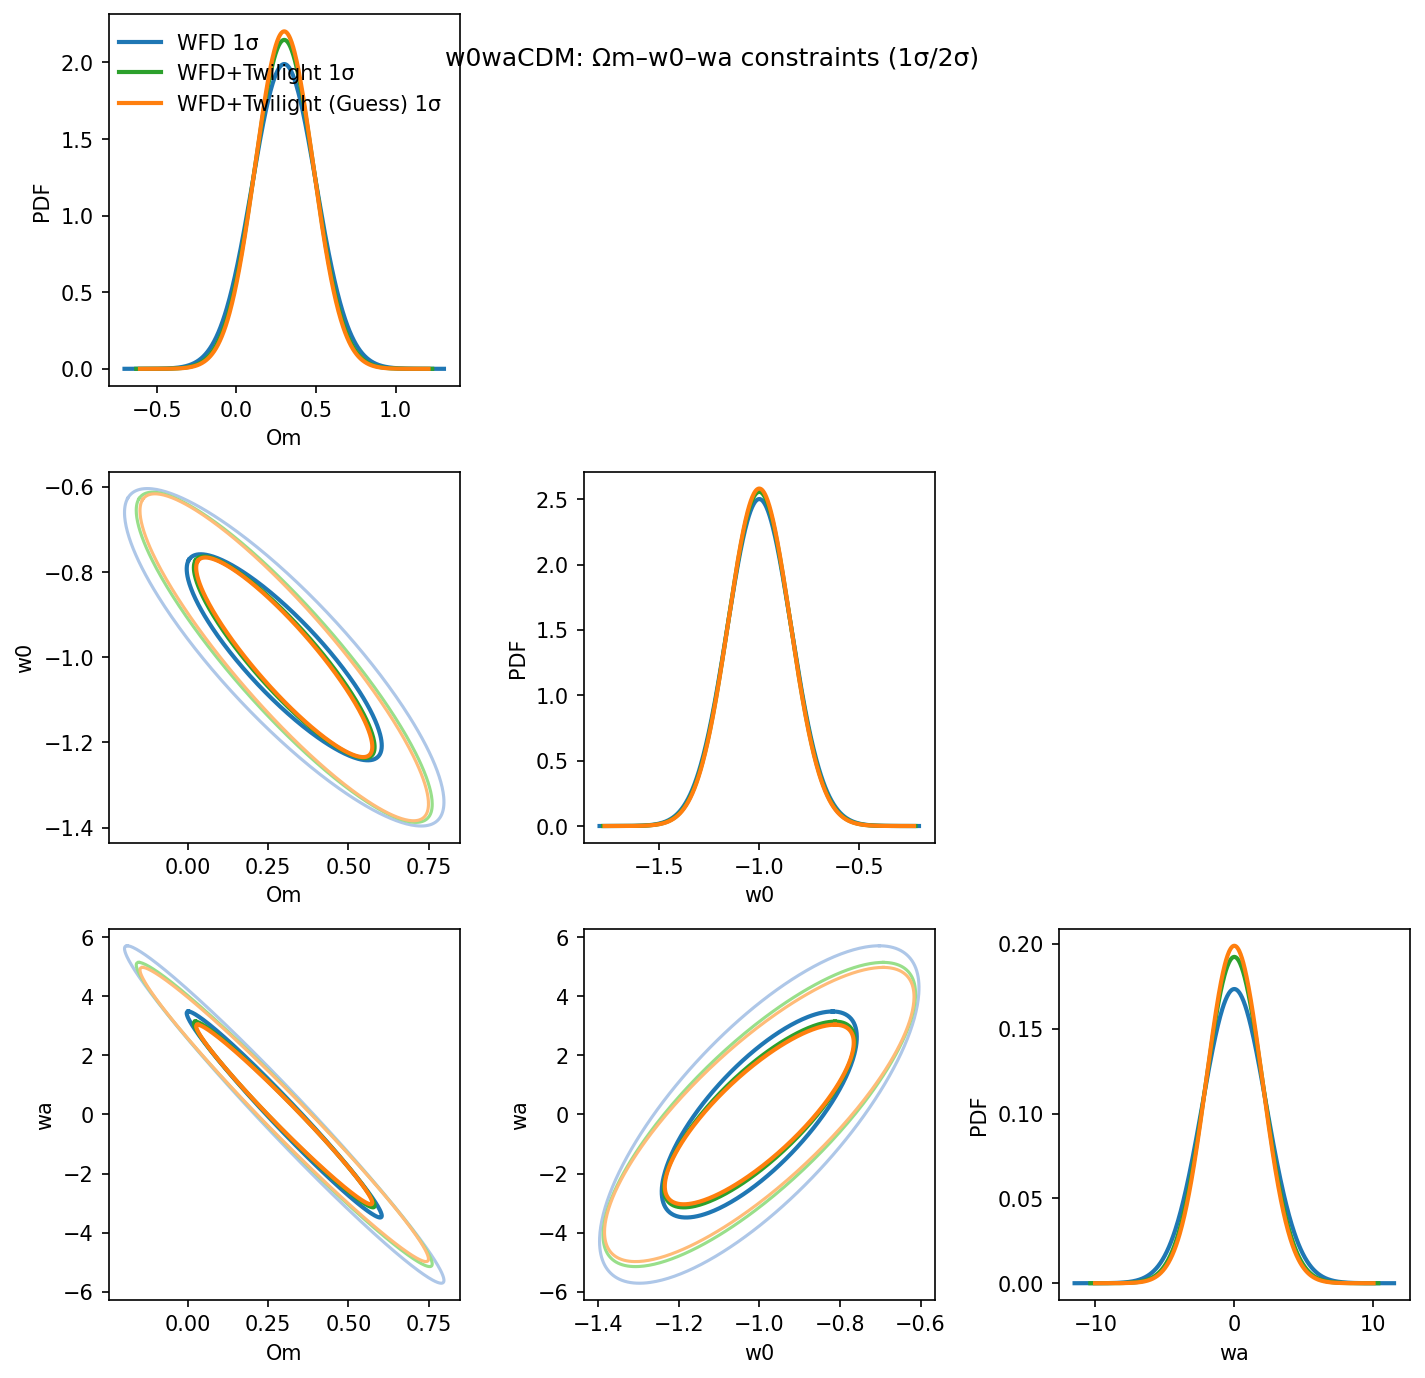

In [ ]:

res_lcdm = run_binned_forecast(df_wfd_bin, df_twfull_bin, model="lcdm")
res_w0wa = run_binned_forecast(df_wfd_bin, df_twfull_bin, model="w0wa")

if df_twguess_bin is not None:
    res_guess_lcdm = run_binned_forecast(df_wfd_bin, df_twguess_bin, model="lcdm")
    res_guess_w0wa = run_binned_forecast(df_wfd_bin, df_twguess_bin, model="w0wa")

plot_lcdm_1d(res_lcdm, param="Om", title="ΛCDM: constraint on Ωm")
plot_corner(res_w0wa, params=("Om","w0","wa"), title="w0waCDM: Ωm–w0–wa constraints (1σ/2σ)")

if df_twguess_bin is not None:
    plot_lcdm_1d_comparison(
        {"WFD": res_lcdm["WFD"], "WFD+Twilight": res_lcdm["WFD+Twilight"], "WFD+Twilight (Guess)": res_guess_lcdm["WFD+Twilight"]},
        param="Om", title="ΛCDM Forecast Comparison"
    )
    plot_corner_comparison(
        {"WFD": res_w0wa["WFD"], "WFD+Twilight": res_w0wa["WFD+Twilight"], "WFD+Twilight (Guess)": res_guess_w0wa["WFD+Twilight"]},
        params=("Om","w0","wa"),
        title="w0waCDM: Ωm–w0–wa constraints (1σ/2σ)"
    )
